In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision

class CloudDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = [d for d in sorted(os.listdir(data_dir)) if os.path.isdir(os.path.join(data_dir, d))]
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        self.images = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            cls_dir = os.path.join(data_dir, cls)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                if os.path.isfile(img_path):  # Verifica que sea un archivo
                    self.images.append(img_path)
                    self.labels.append(idx)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    # Guardar el dataset procesado
    def save_processed_dataset(dataset, file_path):
        torch.save({'images': dataset.images, 'labels': dataset.labels, 'classes': dataset.classes}, file_path)


Tamaño del dataset: 474
Tamaño de un batch: torch.Size([32, 3, 150, 150])
Etiquetas de un batch: tensor([3, 1, 3, 4, 5, 2, 1, 3, 0, 0, 4, 3, 6, 0, 6, 5, 1, 5, 4, 4, 5, 5, 4, 3,
        3, 3, 3, 3, 4, 3, 4, 4])


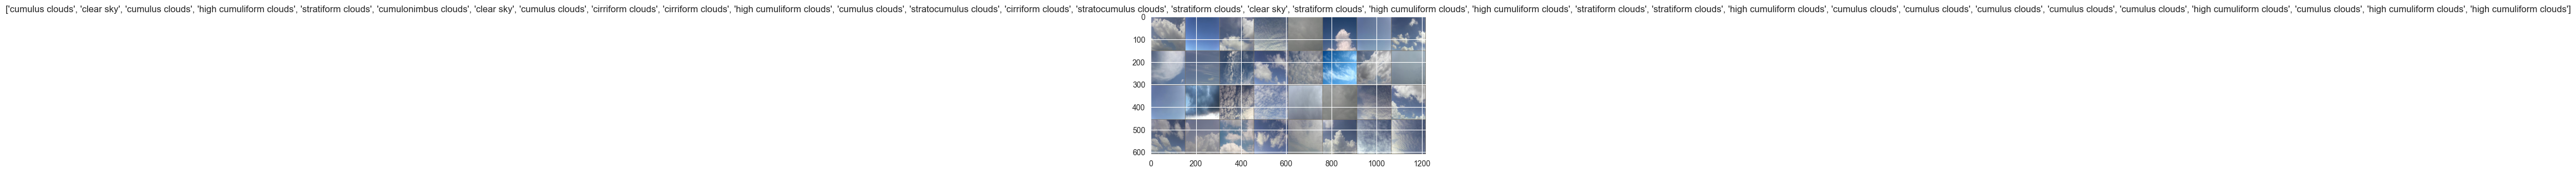

['cumulus clouds', 'clear sky', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'cumulonimbus clouds', 'clear sky', 'cumulus clouds', 'cirriform clouds', 'cirriform clouds', 'high cumuliform clouds', 'cumulus clouds', 'stratocumulus clouds', 'cirriform clouds', 'stratocumulus clouds', 'stratiform clouds', 'clear sky', 'stratiform clouds', 'high cumuliform clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratiform clouds', 'high cumuliform clouds', 'cumulus clouds', 'cumulus clouds', 'cumulus clouds', 'cumulus clouds', 'cumulus clouds', 'high cumuliform clouds', 'cumulus clouds', 'high cumuliform clouds', 'high cumuliform clouds']


In [2]:
# Configuraciones y transformaciones
data_dir = '/Users/adrianinfantes/Desktop/AIR/CollegeStudies/MachineLearningPath/DataCamp/DevelopLLMs/data/raw_data/clouds_data/clouds_train'
batch_size = 32
img_size = (150, 150)

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Creación del dataset y dataloader de entrenamiento
dataset = CloudDataset(data_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Verificación del dataset
data_iter = iter(dataloader)
images, labels = next(data_iter)

print(f"Tamaño del dataset: {len(dataset)}")
print(f"Tamaño de un batch: {images.size()}")
print(f"Etiquetas de un batch: {labels}")

# Función de visualización ajustada
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormalizar
    img = np.clip(img, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

# Mostrar algunas imágenes del batch con sus etiquetas
imshow(torchvision.utils.make_grid(images), title=[dataset.idx_to_class[label.item()] for label in labels])
print([dataset.idx_to_class[label.item()] for label in labels])

In [3]:
# Guardar el dataset procesado

CloudDataset.save_processed_dataset(dataset, 'clouds_train.pth')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

class CloudClassifier(nn.Module):
    def __init__(self, num_classes):
        """
        Constructor de la clase CloudClassifier.
        
        Args:
            num_classes (int): Número de clases (tipos de nubes) en el dataset.
        """
        super(CloudClassifier, self).__init__()
        
        # Definición de las capas de la red neuronal
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) # Primera capa convolucional
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # Segunda capa convolucional
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # Tercera capa convolucional
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Capa de pooling (max pooling). Reduce el tamaño de la capa de convolución
        self.dropout = nn.Dropout(0.5) # Capa de dropout para regularización
        self.fc1 = nn.Linear(128 * 18 * 18, 512) # Primera capa totalmente conectada
        self.fc2 = nn.Linear(512, num_classes) # Segunda capa totalmente conectada
        
    def forward(self, x):
        """
        Propagación hacia adelante (forward) de la red neuronal.
        
        Args:
            x (torch.Tensor): Tensor de entrada con forma (batch_size, 3, 150, 150).
        
        Returns:
            torch.Tensor: Tensor de salida con las predicciones del modelo.
        """
        x = self.pool(F.relu(self.conv1(x)))  # Primera capa convolucional seguida de pooling
        x = self.pool(F.relu(self.conv2(x)))  # Segunda capa convolucional seguida de pooling
        x = self.pool(F.relu(self.conv3(x)))  # Tercera capa convolucional seguida de pooling
        x = x.view(-1, 128 * 18 * 18)  # Aplanamiento del tensor para las capas totalmente conectadas
        x = F.relu(self.fc1(x))  # Primera capa totalmente conectada con ReLU
        x = self.dropout(x)  # Aplicación de dropout para regularización
        x = self.fc2(x)  # Segunda capa totalmente conectada
        return x

    def train_model(model, dataloader, criterion, optimizer, num_epochs):
        """
        Función para entrenar el modelo.
    
        Args:
            model (nn.Module): El modelo de red neuronal a entrenar.
            dataloader (DataLoader): DataLoader para iterar sobre el dataset de entrenamiento.
            criterion (nn.Module): Función de pérdida.
            optimizer (torch.optim.Optimizer): Optimizador para actualizar los pesos del modelo.
            num_epochs (int): Número de épocas para entrenar el modelo.
        
        Returns:
            nn.Module: El modelo entrenado.
        """
        model.train()  # Modo de entrenamiento
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in dataloader:
                optimizer.zero_grad()  # Poner a cero los gradientes
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Cálculo de la pérdida
                loss.backward()  # Backward pass (cálculo de gradientes)
                optimizer.step()  # Actualización de los pesos
                running_loss += loss.item()  # Acumulación de la pérdida
            
            epoch_loss = running_loss / len(dataloader)  # Pérdida promedio por época
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        return model


    # Guardar el modelo entrenado
    def save_model(model, file_path):
        torch.save(model.state_dict(), file_path)
    
    # Cargar el modelo entrenado
    def load_model(model, file_path):
        model.load_state_dict(torch.load(file_path))
        return model


In [5]:
# Configuraciones y entrenamiento
num_classes = len(dataset.classes)
model = CloudClassifier(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 12

trained_model = CloudClassifier.train_model(model, dataloader, criterion, optimizer, num_epochs)

Epoch 1/12, Loss: 1.9765
Epoch 2/12, Loss: 1.4573
Epoch 3/12, Loss: 1.3084
Epoch 4/12, Loss: 1.1488
Epoch 5/12, Loss: 1.0675
Epoch 6/12, Loss: 0.8978
Epoch 7/12, Loss: 0.8421
Epoch 8/12, Loss: 0.6716
Epoch 9/12, Loss: 0.5401
Epoch 10/12, Loss: 0.4132
Epoch 11/12, Loss: 0.3925
Epoch 12/12, Loss: 0.3885


In [6]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


class CloudEvaluator:
    def __init__(self, model, dataloader, class_names):
        self.model = model
        self.dataloader = dataloader
        self.class_names = class_names

    def evaluate(self):
        self.model.eval()  # Modo de evaluación
        all_preds = []
        all_labels = []

        with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
            for inputs, labels in self.dataloader:
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return all_labels, all_preds

    def plot_confusion_matrix(self, labels, preds):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def print_classification_report(self, labels, preds):
        print(classification_report(labels, preds, target_names=self.class_names))

Clases en entrenamiento: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']
Clases en prueba: ['cirriform clouds', 'clear sky', 'cumulonimbus clouds', 'cumulus clouds', 'high cumuliform clouds', 'stratiform clouds', 'stratocumulus clouds']


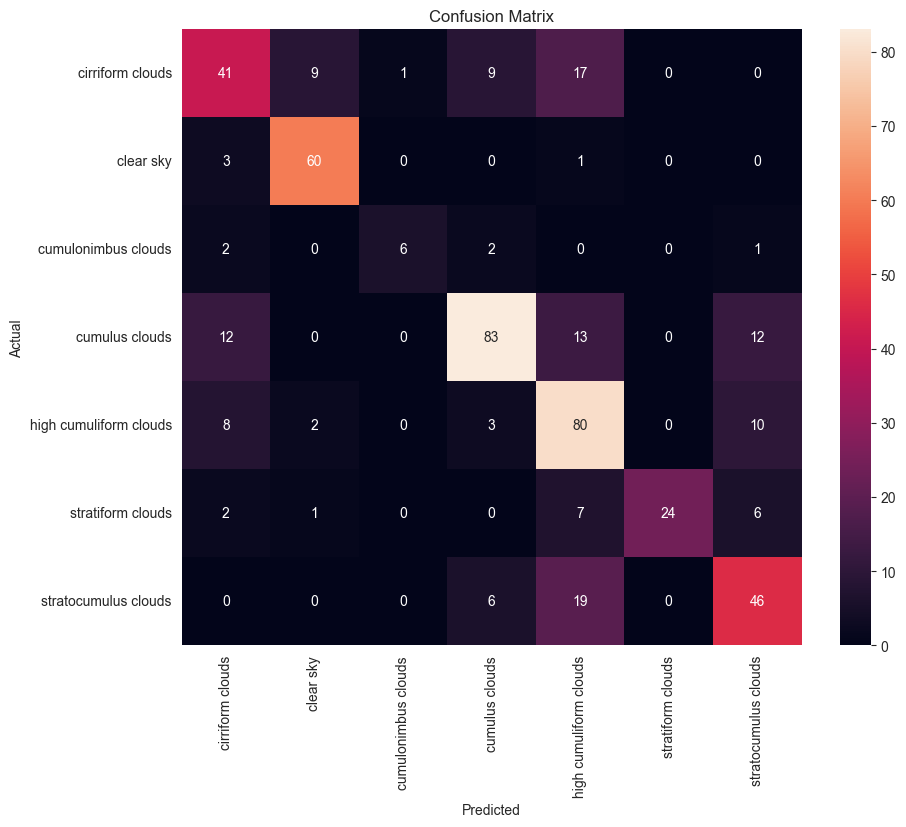

                        precision    recall  f1-score   support

      cirriform clouds       0.60      0.53      0.57        77
             clear sky       0.83      0.94      0.88        64
   cumulonimbus clouds       0.86      0.55      0.67        11
        cumulus clouds       0.81      0.69      0.74       120
high cumuliform clouds       0.58      0.78      0.67       103
     stratiform clouds       1.00      0.60      0.75        40
  stratocumulus clouds       0.61      0.65      0.63        71

              accuracy                           0.70       486
             macro avg       0.76      0.68      0.70       486
          weighted avg       0.72      0.70      0.70       486



In [7]:
# Evaluación del modelo
data_dir_test = '/Users/adrianinfantes/Desktop/AIR/CollegeStudies/MachineLearningPath/DataCamp/DevelopLLMs/data/raw_data/clouds_data/test_data/clouds_test'

# Crear el dataset y dataloader de prueba
test_dataset = CloudDataset(data_dir=data_dir_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar el número de clases y los nombres de las clases
print(f"Clases en entrenamiento: {dataset.classes}")
print(f"Clases en prueba: {test_dataset.classes}")

# Instanciar el evaluador
evaluator = CloudEvaluator(model=trained_model, dataloader=test_dataloader, class_names=test_dataset.classes)

# Realizar la evaluación
labels, preds = evaluator.evaluate()

# Mostrar la matriz de confusión
evaluator.plot_confusion_matrix(labels, preds)

# Imprimir el informe de clasificación
evaluator.print_classification_report(labels, preds)

In [8]:
# Guardar el modelo entrenado

CloudClassifier.save_model(trained_model, 'cloud_classifier.pth')

# Guardar el diccionario de clases

torch.save(dataset.classes, 'classes.pth')

In [9]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image


class CloudPredictor:
    def __init__(self, model, class_names, img_size=(150, 150)):
        self.model = model
        self.class_names = class_names
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        image = image.unsqueeze(0)  # Añadir una dimensión para el batch

        with torch.no_grad():
            outputs = self.model(image)
            _, preds = torch.max(outputs, 1)
        
        predicted_class = self.class_names[preds.item()]
        return predicted_class

In [10]:
# Cargar el modelo entrenado
trained_model = CloudClassifier(num_classes=len(dataset.classes))
trained_model = CloudClassifier.load_model(trained_model, 'cloud_classifier.pth')

# Instanciar el predictor
predictor = CloudPredictor(model=trained_model, class_names=torch.load('classes.pth'))

# Hacer una predicción
image_path = '/Users/adrianinfantes/Desktop/AIR/CollegeStudies/MachineLearningPath/DataCamp/DevelopLLMs/data/raw_data/clouds_data/test_data/clouds_test/cumulonimbus clouds/c2340cdc7d40d5ad33927e9be8383954.jpg'
predicted_class = predictor.predict(image_path)
print(f'Predicted class: {predicted_class}')

Predicted class: stratocumulus clouds
